## TABLE DES MATIERES

### 0.1 Import Librairies
### 0.2 Read_csv
### 0.3


## 0. Import Librairies

In [1]:
import time
tic = time.time()

import numpy as np
import pandas as pd
import gc
import os
import glob
import shap

from contextlib import contextmanager

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import mlflow
import mlflow.sklearn
from mlflow import MlflowClient

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

separator_line = '\n\n'+'\033[1m_\033[0m'*100+'\n'+'\033[1m_\033[0m'*100+'\n\n'
pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 4000)
pd.set_option('display.width', 1000)

### 0.2 Read_csv

##### The column description csv file describes the Target field as follows:

1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample

0 - all other cases

In [2]:
# DataFrame
# df = pd.read_csv('./output_datasets/DataFrame.csv')

# Test
X_test = pd.read_csv('./output_datasets/X_test.csv')
y_test = pd.read_csv('./output_datasets/y_test.csv')

X_test = X_test.set_index('SK_ID_CURR')
y_test = y_test.set_index('SK_ID_CURR')

# Train
X_train = pd.read_csv('./output_datasets/X_train.csv')
y_train = pd.read_csv('./output_datasets/y_train.csv')

features = X_train.columns
# X_train = X_train.to_numpy()
y_train = y_train['TARGET'].to_numpy()

### 0.3 Display's functions

In [3]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, features_importance, features=features, importance_range=30 ):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    cf_matrix_normalize_true = confusion_matrix(y_true, y_pred, normalize='true')
    cf_matrix_normalize_all = confusion_matrix(y_true, y_pred, normalize='all')
    
    group_names = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_normalize_true = ["{0:.2%}".format(value) for value in cf_matrix_normalize_true.flatten()]
    group_normalize_all = ["{0:.2%}".format(value) for value in cf_matrix_normalize_all.flatten()]
  
    labels = [f"{v1}\ncount : {v2}\nnormalize over true : {v3}\nnormalize over all : {v4}" for v1, v2, v3, v4 in zip(group_names,group_counts,group_normalize_true,group_normalize_all)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5)#, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if features_importance : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
        features = features[:importance_range]
        
        sns.barplot(x=features, y=model.feature_importances_[indices[range(importance_range)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)
    plt.show()
    plt.close('all')
    return

In [4]:
def plt_scores(model_dict, fist_bar_position = 1, 
               first_bar_label='cross validation roc score', 
               second_bar_position = 2, 
               second_bar_label='true & predict roc score'):
    
    ziped_dict = list(zip(*model_dict.values()))
    ziped_dict[fist_bar_position]
    ziped_dict[second_bar_position]
    
    plt.rcParams["figure.figsize"] = (3,3)
    plt.figure()
    plt.title('Scores', fontsize=20)
    plt.ylabel('Model',fontsize=10)
    plt.xlabel('score',fontsize=10)
    
    X_axis = np.arange(len(model_dict))
    width=1/5
    
    plt.barh(X_axis+width, ziped_dict[fist_bar_position], width*2, label=first_bar_label)
    plt.barh(X_axis-width, ziped_dict[second_bar_position], width*2, label=second_bar_label)
    
    plt.yticks(X_axis, model_dict.keys())
    plt.xlim([0,1])
    plt.tick_params( length =5, labelsize=10)
    plt.grid(linewidth=0.5, color = 'black')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.margins(0.001)
    plt.show()
    plt.close()
    return

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s\n\n".format(title, time.time() - t0)+"-"*50)

### 1.1 Classification's models

In [97]:
def create_or_read_model(create=False, version=1, score='roc_auc',cv=5, reg_model_name=None, Estimator=None, param_grid=None):
    if create:
        time_start=time.time()
        with mlflow.start_run(run_name=reg_model_name) as run:
            
            grid = GridSearchCV(eval(Estimator),
                                param_grid=param_grid,
                                scoring=score,
                                cv=cv,
                                verbose=10)
            
            grid.fit(X_train, y_train)
            mlflow.log_params(param_grid)
            mlflow.sklearn.log_model(sk_model = grid,
                                    artifact_path="classifier",
                                    registered_model_name=reg_model_name)
            time_end=time.time()
            model = grid
            time = round((time_end-time_start)/60,2)
            np.save(f'./Execution_model_time/{reg_model_name}_{version}.npy', np.array(time))
    else :
        model_uri = f"models:/{reg_model_name}/{version}"
        model = mlflow.sklearn.load_model(model_uri)
        time = np.load(f'./Execution_model_time/{reg_model_name}_{version}.npy')
        
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    model_best_score = model.best_score_
    roc_score = roc_auc_score(y_pred, y_test)
    beta_score = fbeta_score(y_pred, y_test, beta=0.5, pos_label=0)

    #OUTPUT

    print('\n\n'+reg_model_name+' : ')
    print(f"\n\texecution time : {time}")
    print(f"\n\tbest_score_ : {round(model_best_score,3)}")
    print(f"\n\troc_auc_score : {round(roc_score,3)}")
    print(f"\n\tbeta_score : {round(beta_score,3)}")
    cf_matrix_roc_auc(model, y_test, y_pred, y_pred_proba[:,1], features_importance=False)
    print(separator_line)
    
    return model, model_best_score, roc_score, beta_score #, time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




DummyClassifier : 

	execution time : 0

	best_score_ : 0.5

	roc_auc_score : 0.501

	beta_score : 0.551


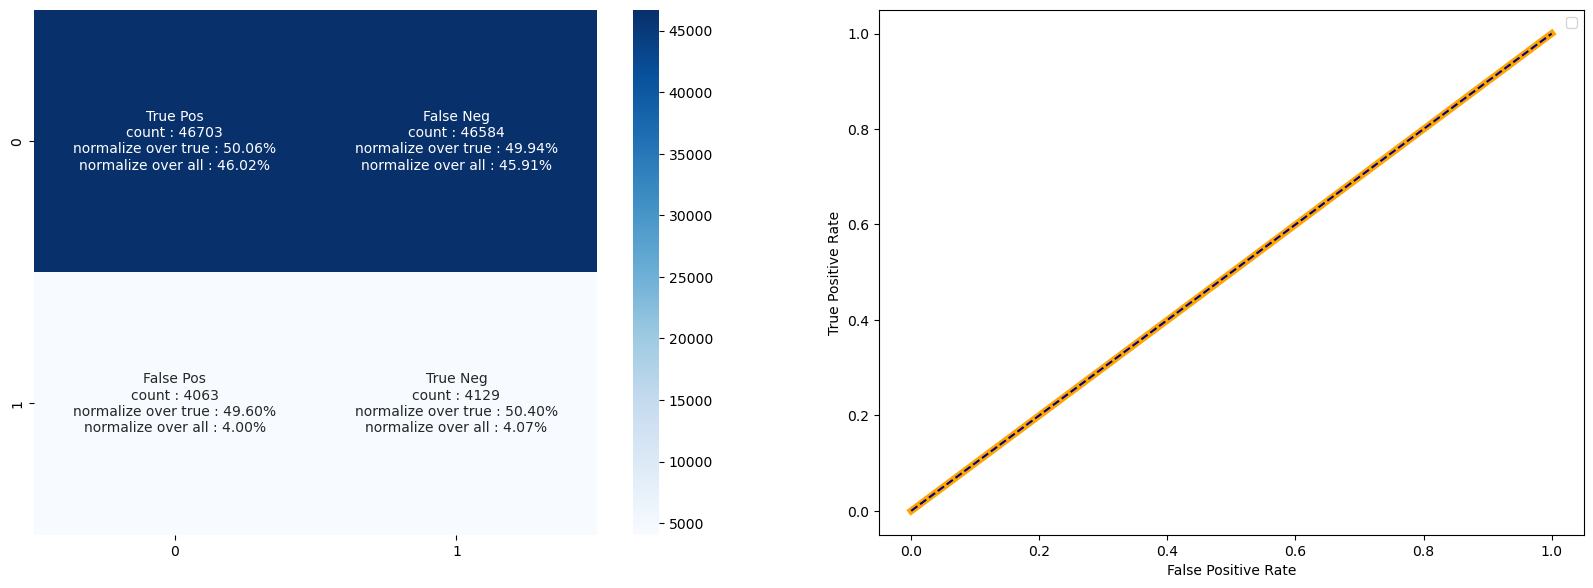



____________________________________________________________________________________________________
____________________________________________________________________________________________________




LogisticRegression : 

	execution time : 0

	best_score_ : 0.805

	roc_auc_score : 0.563

	beta_score : 0.754


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


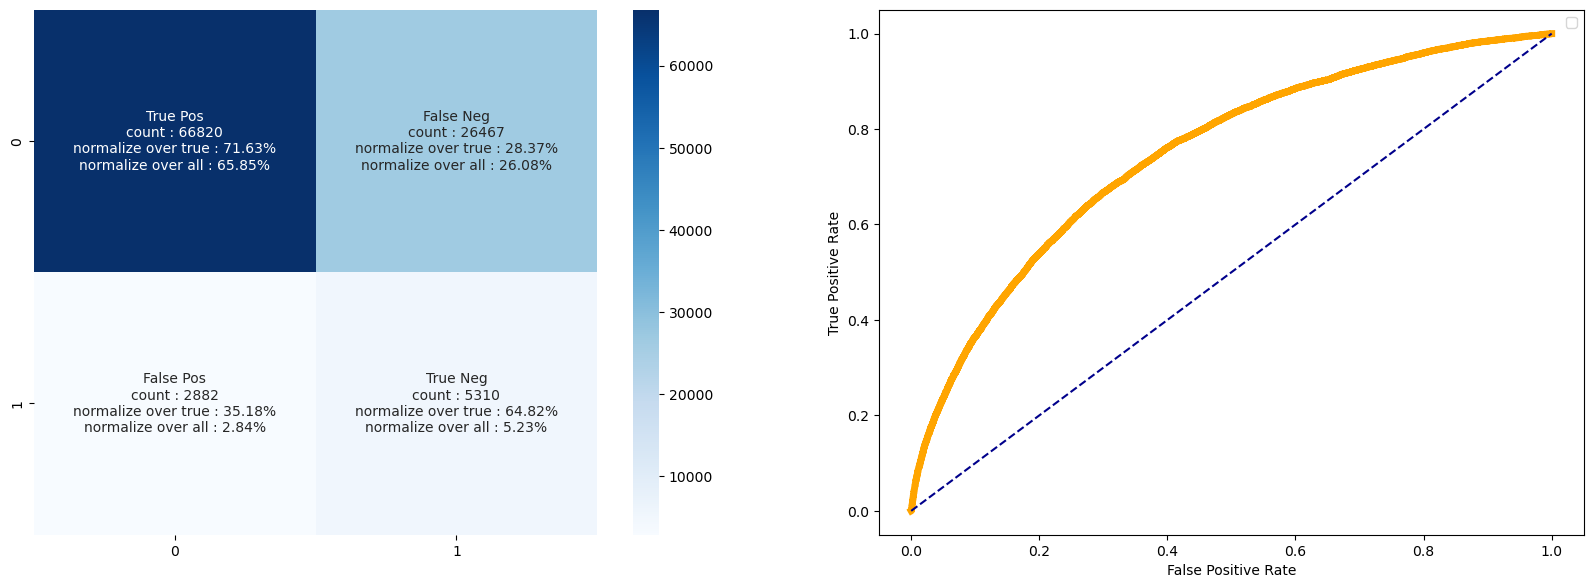



____________________________________________________________________________________________________
____________________________________________________________________________________________________




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




RandomForestClassifier : 

	execution time : 0

	best_score_ : 0.985

	roc_auc_score : 0.607

	beta_score : 0.98


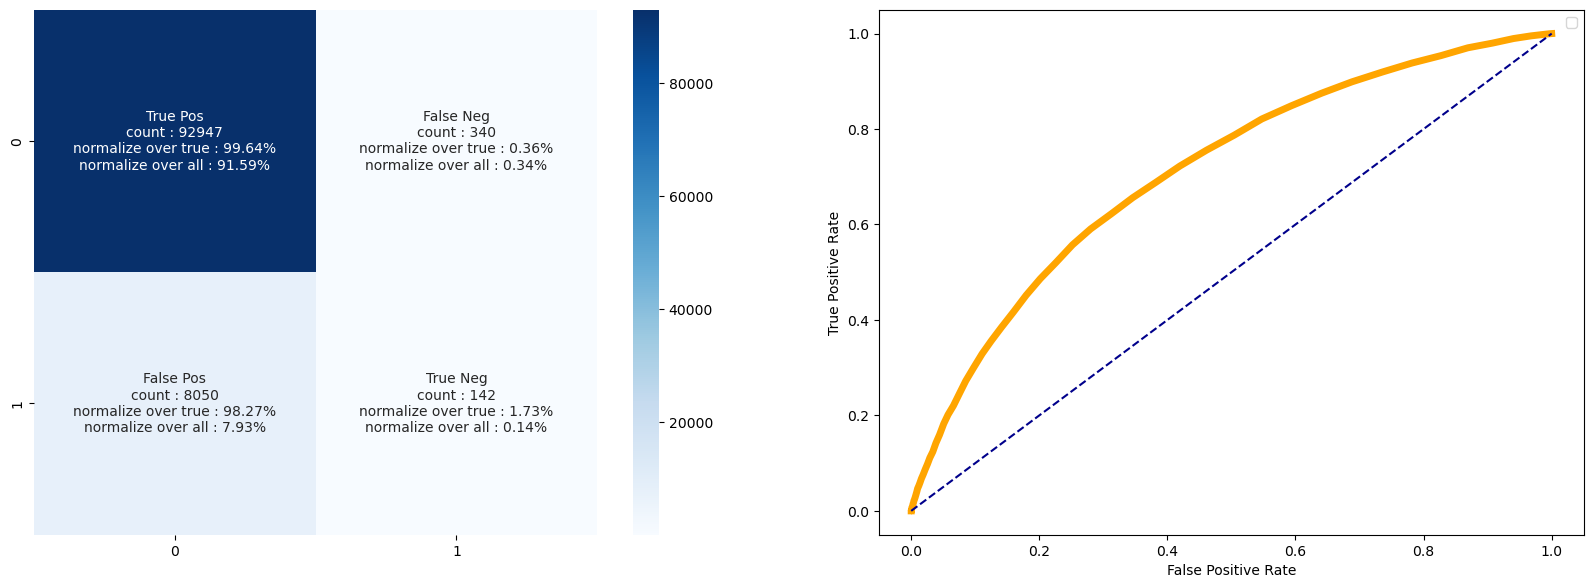



____________________________________________________________________________________________________
____________________________________________________________________________________________________




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




LGBMClassifier : 

	execution time : 0

	best_score_ : 0.969

	roc_auc_score : 0.735

	beta_score : 0.981


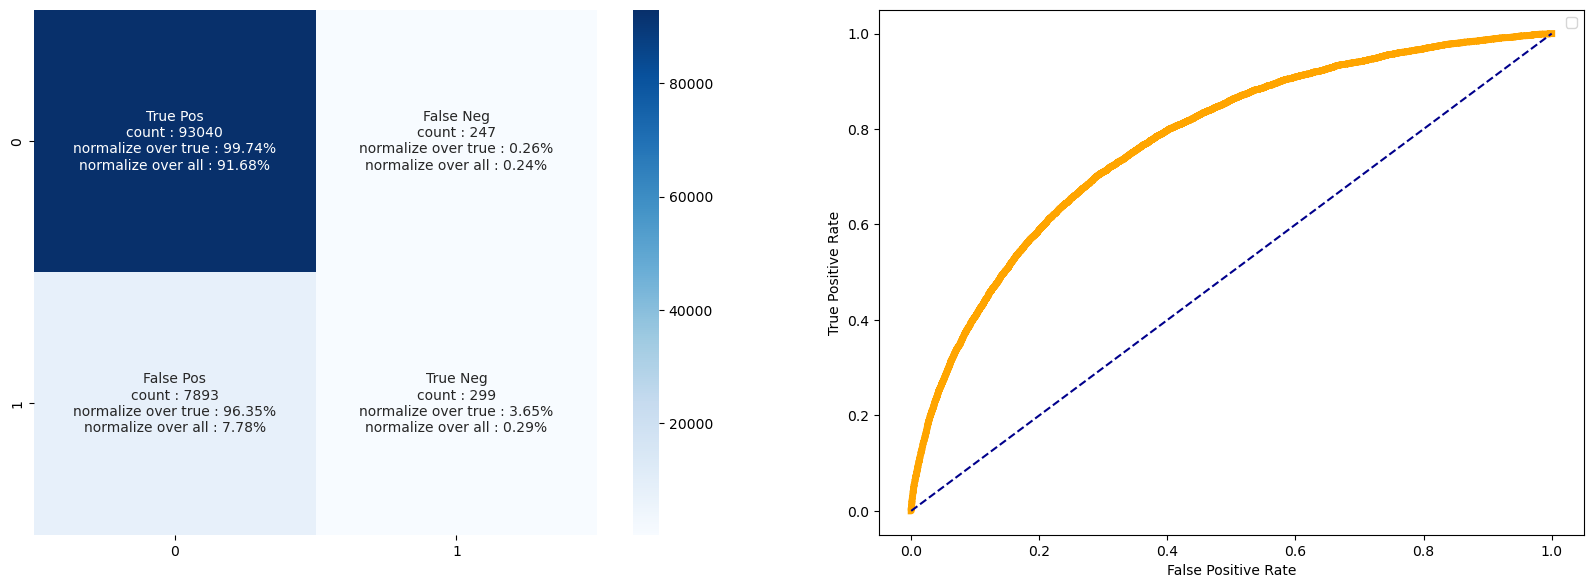



____________________________________________________________________________________________________
____________________________________________________________________________________________________




In [98]:
model_dict ={}
model_dict["DummyClassifier"] = create_or_read_model(create=False, 
                                    version=1, 
                                    score='roc_auc',
                                    cv=5, 
                                    reg_model_name="DummyClassifier", 
                                    Estimator="DummyClassifier()", 
                                    param_grid={'strategy' : ['stratified', 'uniform']})

model_dict["LogisticRegression"] = create_or_read_model(create=False, 
                                    version=1, 
                                    score='roc_auc',
                                    cv=5, 
                                    reg_model_name="LogisticRegression", 
                                    Estimator="LogisticRegression()", 
                                    param_grid = {'penalty' : ['l2'],
                                                  'max_iter' : [1000]}
                                    )
model_dict["RandomForestClassifier"] = create_or_read_model(create=False, 
                                    version=1, 
                                    score='roc_auc',
                                    cv=5, 
                                    reg_model_name="RandomForestClassifier", 
                                    Estimator="RandomForestClassifier()", 
                                    param_grid = {'criterion' : ['gini', 'entropy'],
                                                  'max_depth' : [200]}
                                    )
model_dict["LGBMClassifier"] = create_or_read_model(create=False, 
                                    version=1, 
                                    score='roc_auc',
                                    cv=5, 
                                    reg_model_name="LGBMClassifier", 
                                    Estimator="LGBMClassifier()", 
                                    param_grid = {'n_estimators' : [1000],
                                      'learning_rate' : [0.02],
                                      'max_depth' : [8]}
                                    )

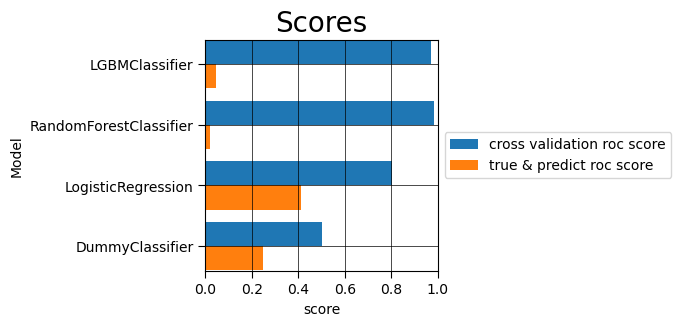

In [78]:
plt_scores(model_dict, 
           fist_bar_position = 1, 
           first_bar_label='cross validation roc score', 
           second_bar_position = 3, 
           second_bar_label='true & predict roc score')

# plt_scores(model_dict)

Specificity score:
https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Specificity

In [85]:
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Specificity

from sklearn.metrics import precision_score

def specificity(y_true, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_true, y_pred).ravel()
    return tn/(tn + fp)

specificity_score = make_scorer(specificity)




def custom_metric(y_true,y_pred):
    tp, fn, fp, tn = confusion_matrix(y_true, y_pred).ravel()
#     return (1 - fp/(fp+tn))
    return fn+fp*10

custom_score = make_scorer(custom_metric, greater_is_better=False)


# pos_label

fbeta_500_scorer = make_scorer(fbeta_score, beta=50, pos_label=0)

In [86]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate

device = 'gpu'
n_estimators = 10
n_KFolds = 3
max_evals = 5

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'reg_alpha' : int(params['reg_alpha']),
        'min_child_weight' : int(params['min_child_weight']),
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device' : device,
        'n_estimators': n_estimators,
        }
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(n_KFolds)
    y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
    beta_score = fbeta_score(y_train, y_pred, beta=0.5, pos_label=0)
#     score = specificity(y_train, y_pred)
    return {'loss': (1 - beta_score), 'status': STATUS_OK }

def LGBM_hyperopt(run_name):
    space = {
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
        'max_depth': hp.quniform('max_depth', 10, 30, 10),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'subsample': hp.uniform('subsample', 0.60, 0.95),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
        'reg_lambda': hp.uniform('reg_lambda', 1, 20),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        }
    trials = Trials()
    best = fmin(fn=objective, space=space, max_evals=max_evals, algo=tpe.suggest)
    with mlflow.start_run(run_name=run_name) as run:
        lgbm = LGBMClassifier(
            max_depth= int(best['max_depth']),
            reg_alpha=int(best['reg_alpha']),
            min_child_weight=int(best['min_child_weight']),
            learning_rate= best['learning_rate'],
            subsample= best['subsample'],
            colsample_bytree= best['colsample_bytree'],
            reg_lambda= best['reg_lambda'],
            n_estimators=n_estimators,
            device=device
            )
        lgbm.fit(X_train, y_train)
        mlflow.log_params(best)
        mlflow.sklearn.log_model(sk_model = lgbm,
                                    artifact_path="classifier",
                                    registered_model_name=run_name)
    return
LGBM_hyperopt(run_name='LGBM_Hyperopt_specificity')

100%|██████| 5/5 [02:05<00:00, 25.20s/trial, best loss: 0.1672742938895101]


Registered model 'LGBM_Hyperopt_specificity' already exists. Creating a new version of this model...
2023/03/20 15:31:06 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM_Hyperopt_specificity, version 3
Created version '3' of model 'LGBM_Hyperopt_specificity'.


In [88]:
model_uri = "models:/LGBM_Hyperopt_specificity/3"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


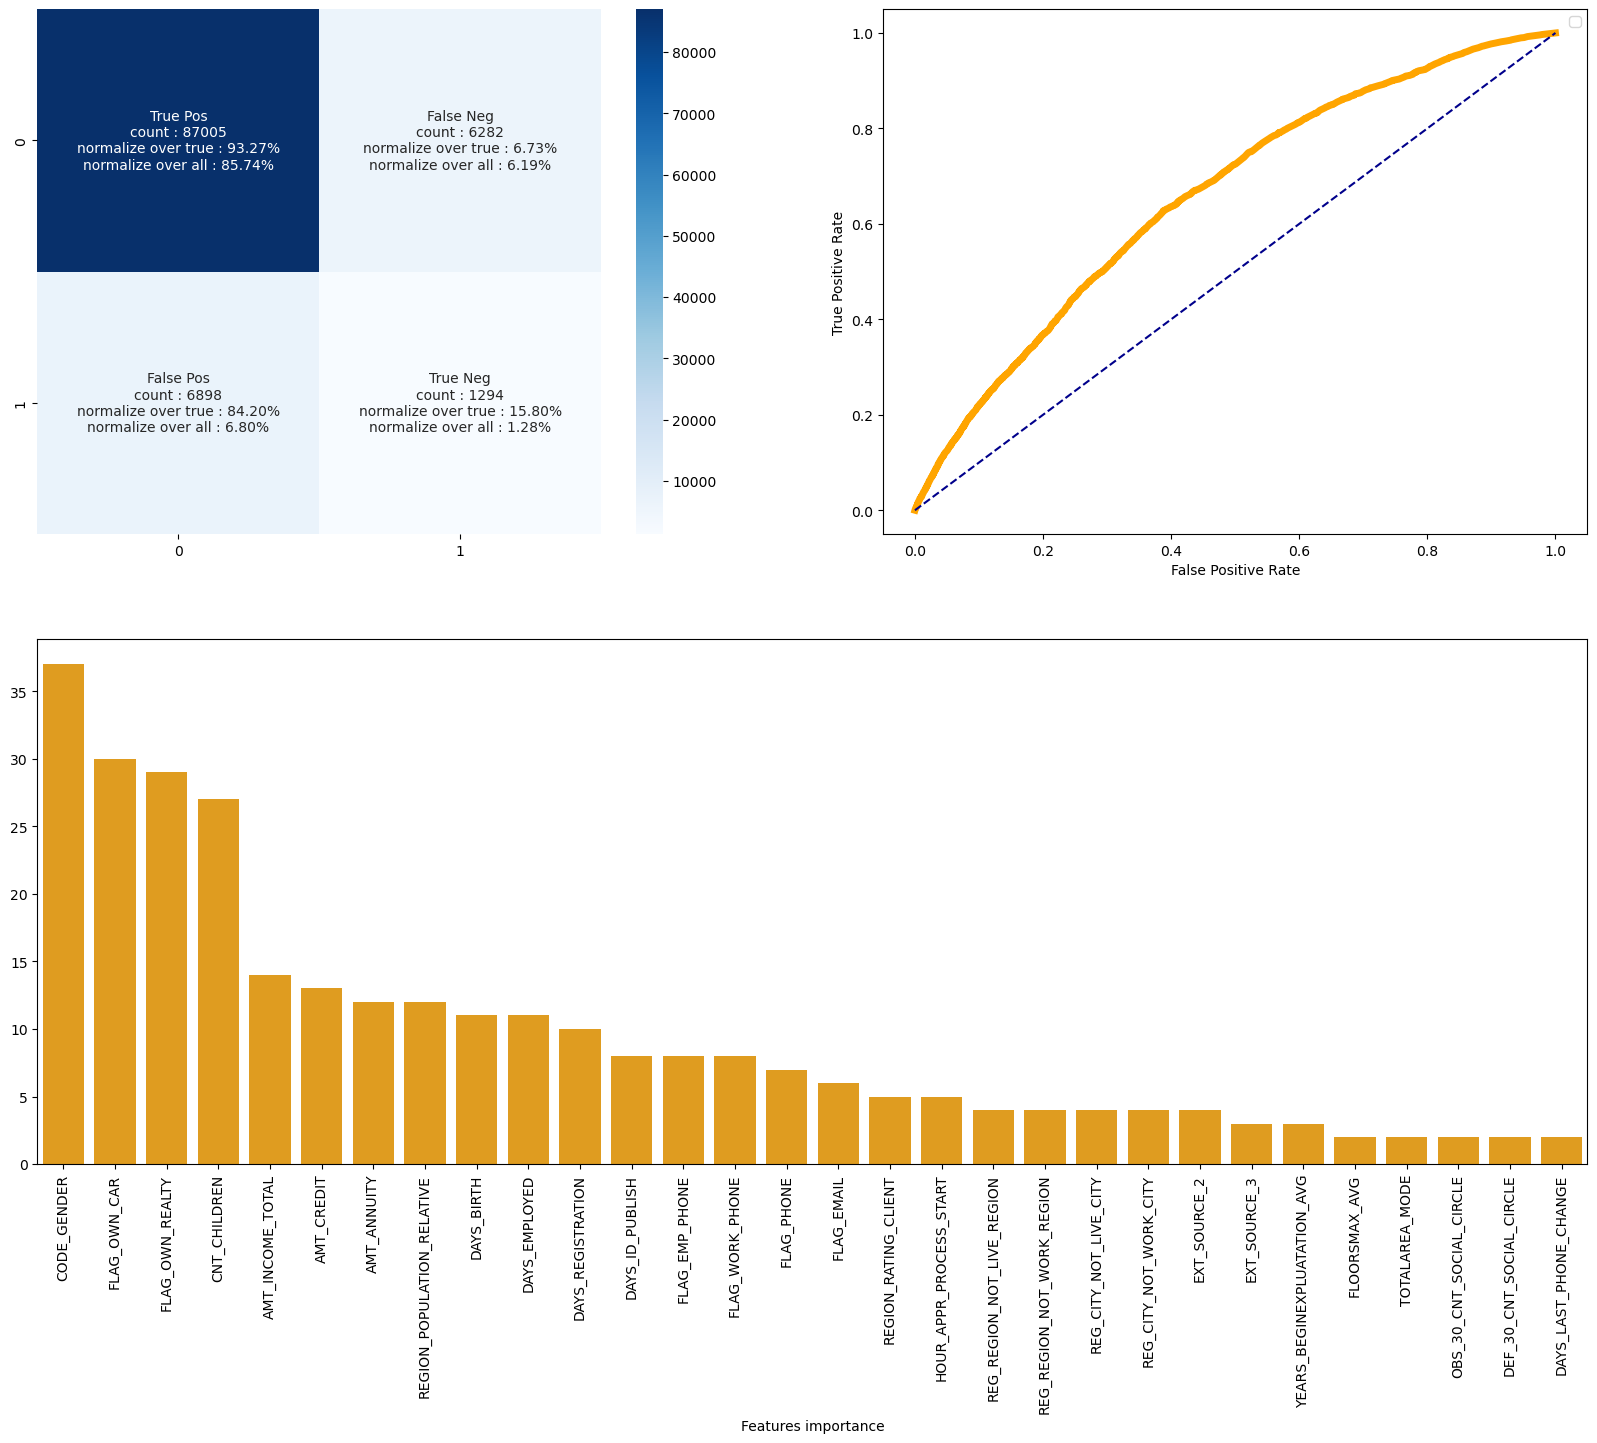

In [89]:
model = mlflow.sklearn.load_model(model_uri)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# estimator.append(key)
# grid_best_score.append(loaded_model.best_score_)
# roc_score.append(roc_auc_score(y_pred, y_test))
# fbeta_500_score.append(fbeta_score(y_pred, y_test, beta=50))

# print(key+' : ')
# print(f" roc_auc_score : {round(roc_auc_score(y_pred, y_test),3)}")
cf_matrix_roc_auc(model, y_test, y_pred, y_pred_proba[:,1], features_importance=True)


In [ ]:
def X_sample(create=False):
    if create:
        X_test_sample = X_test.sample(300)
        X_test_sample.to_csv('./output_datasets/X_test_sample.csv')
        X_test_sample.to_csv(r"C:\Users\emanu\Documents\FastAPI\X_test_sample.csv", index=False)
    X_test_sample = pd.read_csv('./output_datasets/X_test_sample.csv',index_col='SK_ID_CURR')
    return X_test_sample

def prediction_shap_model(X_test_sample, create=False, model_uri="models:/LGBM_Hyperopt_specificity/1" ):
    if create:
        # load model
        model = mlflow.sklearn.load_model(model_uri)
        # predict
        y_pred = model.predict(X_test_sample)
        y_pred_proba = model.predict_proba(X_test_sample)
        y_pred_proba = list(zip(*y_pred_proba))
        id_list = X_test_sample.index.tolist()
        # predict dataframe
        prediction_df = pd.DataFrame()
        prediction_df['id'] = id_list
        prediction_df['y_pred'] = y_pred
        prediction_df['y_proba_0'] = y_pred_proba[0]
        prediction_df['y_proba_1'] = y_pred_proba[1]
        # shap
        with mlflow.start_run() as run:
            mlflow.shap.log_explanation(model.predict, X_test_sample)
        client = MlflowClient()
        artifact_path = "model_explanations_shap"
        artifacts = [x.path for x in client.list_artifacts(run.info.run_id, artifact_path)]
        dst_path = client.download_artifacts(run.info.run_id, artifact_path)
        base_values = np.load(os.path.join(dst_path, "base_values.npy"))
        shap_values = np.load(os.path.join(dst_path, "shap_values.npy"))
        
        
        # save results on Projet_7 folder
        np.save("./output_datasets/model_explanations_shap/base_values.npy",shap_values)
        np.save("./output_datasets/model_explanations_shap/shap_values.npy",shap_values)
        prediction_df.to_csv('./output_datasets/prediction_X_test_sample_df.csv', index=False)
        # save results on FastAPI folder
        np.save(r"C:\Users\emanu\Documents\FastAPI\model_explanations_shap\base_values.npy",shap_values)
        np.save(r"C:\Users\emanu\Documents\FastAPI\model_explanations_shap\shap_values.npy",shap_values)
        prediction_df.to_csv(r"C:\Users\emanu\Documents\FastAPI\prediction_X_test_sample_df.csv", index=False)
    # read
    base_values = np.load("./output_datasets/model_explanations_shap/base_values.npy")
    shap_values = np.load("./output_datasets/model_explanations_shap/shap_values.npy")
    prediction_df = pd.read_csv('./output_datasets/prediction_X_test_sample_df.csv', index_col='id')
    return base_values, shap_values, prediction_df

# run functions
X_test_sample = X_sample(create=False)
base_values, shap_values, prediction_df = prediction_shap_model(X_test_sample, create=False, model_uri="models:/LGBM_Hyperopt_specificity/1")

# SHOW
print('X_test_sample')
display(X_test_sample.head(5))
print('base_values')
print(base_values)
print('shap_values')
print(shap_values)
print('prediction_df')
display(prediction_df.head(5))

In [ ]:
toc=time.time()
print(f"Notebook execution time : {round((toc-tic)/60,2)} min")

In [ ]:
# import pickle
# model_pickle = pickle.load(open('model.pkl','rb'))
# sk_id = 141817
# y_pred = model_pickle.predict(X_test.loc[X_test.index == sk_id])[0]
# y_pred

In [ ]:
import pickle
# save the model to disk for the API
filename = r"C:\Users\emanu\Documents\FastAPI\final_model.sav"
pickle.dump(model, open(filename, 'wb'))

# check if model is correcly loaded
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

In [ ]:
# check if model is correcly loaded
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

In [ ]:
proba_0 = model.predict_proba(X_test)
proba_0 = [i*100 for i in list(zip(*proba_0))[0]]
all_proba = pd.DataFrame()
all_proba['prob'] = proba_0
all_proba.to_csv(r"C:\Users\emanu\Documents\Dash_app\all_proba.csv", index=False)
pd.read_csv(r"C:\Users\emanu\Documents\Dash_app\all_proba.csv")

In [ ]:
cv = 4
time_start=time.time()
reg_model_name = "LogisticRegression_betascore"

Estimator = "LogisticRegression()"
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet'],
              'max_iter' : [2000],
              'solver':['lbfgs', 'liblinear', 'newton-cholesky']              
             }
with mlflow.start_run(run_name=reg_model_name) as run:
    
    grid = GridSearchCV(eval(Estimator),
                        param_grid=param_grid,
                        scoring=fbeta_500_scorer,
                        cv=cv,
                        verbose=10
                       )
    grid.fit(X_train, y_train)
    mlflow.log_params(param_grid)
    mlflow.sklearn.log_model(sk_model = grid,
                            artifact_path="classifier",
                            registered_model_name=reg_model_name)
    time_end=time.time()        
    print(reg_model_name+" execution time : {}min".format(round((time_end-time_start)/60,2)))